# Поиск товаров - загрузка готовой базы данных


## 1. Установка библиотек


In [1]:
%pip install transformers torch pillow faiss-cpu pandas pyarrow


Note: you may need to restart the kernel to use updated packages.


## 2. Загрузка CLIP модели


In [2]:
from transformers import CLIPProcessor, CLIPModel
import torch

# Используем легкую модель CLIP
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f"Модель загружена на {device}")


/Users/stepan/main/recsys-cw/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Модель загружена на cpu


## 3. Загрузка FAISS индекса


In [5]:
import faiss

# Загружаем FAISS индекс (сохранен через faiss.write_index)
index = faiss.read_index("../vector_store/faiss_index.bin")
print(f"FAISS индекс загружен: {index.ntotal} векторов, размерность {index.d}")


FAISS индекс загружен: 10000 векторов, размерность 512


## 4. Загрузка метаданных


In [7]:
import pickle

# Загружаем метаданные (сохранены через pickle.dump)
# Структура: metadata = {'df_filtered': df_filtered, 'images': images}
with open("../data/embeddings/metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

df_filtered = metadata['df_filtered']
images = metadata['images']

print(f"Метаданные загружены из metadata.pkl")
print(f"  - Датафрейм: {len(df_filtered)} записей")
print(f"  - Изображения: {len(images)} штук")


ValueError: not enough values to unpack (expected 2, got 1)

## 5. Функции для создания эмбеддингов


In [4]:
import numpy as np

def get_text_embedding(text):
    """Создает эмбеддинг для текста"""
    inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        outputs = model.get_text_features(**inputs)
    
    return outputs.cpu().numpy()[0]


## 6. Поиск по тексту


In [5]:
def search_by_text(query_text, k=5):
    """Поиск товаров по текстовому запросу"""
    # Создаем эмбеддинг для запроса
    query_embedding = get_text_embedding(query_text)
    query_embedding = query_embedding.reshape(1, -1).astype('float32')
    faiss.normalize_L2(query_embedding)
    
    # Ищем ближайшие векторы
    distances, indices = index.search(query_embedding, k)
    
    # Возвращаем результаты
    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        results.append({
            'rank': i + 1,
            'index': int(idx),
            'similarity': float(dist),
            'caption': df_filtered.iloc[idx]['caption'],
            'image': images[idx]
        })
    
    return results

# Пример поиска
query = "черное платье"
results = search_by_text(query, k=3)

print(f"Результаты поиска по запросу: '{query}'")
for r in results:
    print(f"\n{r['rank']}. Сходство: {r['similarity']:.3f}")
    print(f"   Описание: {r['caption']}")


Результаты поиска по запросу: 'черное платье'

1. Сходство: 0.260
   Описание: Стильный свитер и подходящие джинсы.

2. Сходство: 0.257
   Описание: Спортивный наряд для тренировки.

3. Сходство: 0.252
   Описание: Теплое розовое платье с глубоким вырезом.


## 7. Поиск по изображению


In [6]:
def search_by_image(query_image, k=5):
    """Поиск товаров по изображению"""
    # Создаем эмбеддинг для изображения
    inputs = processor(images=[query_image], return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        query_embedding = model.get_image_features(**inputs).cpu().numpy()[0]
    
    query_embedding = query_embedding.reshape(1, -1).astype('float32')
    faiss.normalize_L2(query_embedding)
    
    # Ищем ближайшие векторы
    distances, indices = index.search(query_embedding, k)
    
    # Возвращаем результаты
    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        results.append({
            'rank': i + 1,
            'index': int(idx),
            'similarity': float(dist),
            'caption': df_filtered.iloc[idx]['caption'],
            'image': images[idx]
        })
    
    return results

# Пример поиска по изображению (берем первое изображение как запрос)
query_img = images[0]
results = search_by_image(query_img, k=3)

print(f"Результаты поиска по изображению:")
for r in results:
    print(f"\n{r['rank']}. Сходство: {r['similarity']:.3f}")
    print(f"   Описание: {r['caption']}")


Результаты поиска по изображению:

1. Сходство: 1.000
   Описание: Стильный женский свитер с V-образным вырезом и узкими рукавами.

2. Сходство: 0.891
   Описание: Элегантная блузка с открытой спиной и стильные джинсы.

3. Сходство: 0.883
   Описание: Стильный бордовый свитер с вырезом и черными джинсами.


## 8. Визуализация результатов


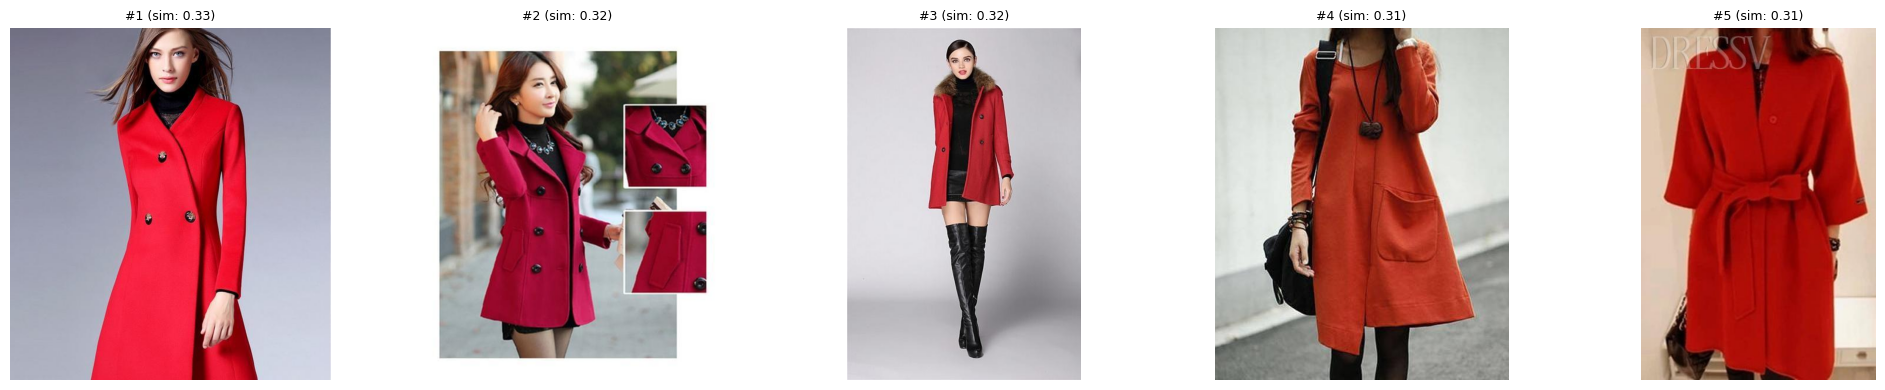

In [10]:
import matplotlib.pyplot as plt

def visualize_results(results, query_text=None, query_image=None):
    """Визуализирует результаты поиска"""
    n_results = len(results)
    cols = n_results + (1 if query_image else 0)
    
    fig, axes = plt.subplots(1, cols, figsize=(4*cols, 4))
    if cols == 1:
        axes = [axes]
    
    idx = 0
    
    # Показываем запрос (если это изображение)
    if query_image:
        axes[idx].imshow(query_image)
        axes[idx].set_title("Запрос", fontsize=10)
        axes[idx].axis('off')
        idx += 1
    
    # Показываем результаты
    for r in results:
        axes[idx].imshow(r['image'])
        title = f"#{r['rank']} (sim: {r['similarity']:.2f})"
        axes[idx].set_title(title, fontsize=9)
        axes[idx].axis('off')
        idx += 1
    
    plt.tight_layout()
    plt.show()

# Пример визуализации текстового поиска
results = search_by_text("red coat", k=5)
visualize_results(results, query_text="красная сумка")
